**Penguin Species Classification**

I will explore the *penguins.csv* dataset and apply **machine learning models**. First, I will perform **data exploration** and **feature selection** to identify key variables. Then, I'll **train various models** (Logistic Regression, KNN, SVM, Random Forest) and evaluate them using metrics such as **accuracy, F1-score**, and **AUC**. Finally, I’ll perform **hyperparameter tuning** to improve model performance.

Key steps:
1. **Data Exploration**: Inspect the dataset, handle missing values, and visualize feature distributions.
2. **Feature Selection**: Choose the most relevant features for model training.
3. **Model Training**: Apply different models and evaluate their performance.
4. **Model Evaluation**: Use confusion matrices, classification reports, and **ROC curves** to assess models.
5. **Hyperparameter Tuning**: Use GridSearchCV to optimize model performance.

**🔍 More details and comments are available at the end of the file.**

**#0 Imports**

In [1]:
# Standard libraries
import warnings
from scipy import stats

# Data manipulation and analysis
import pandas as pd
import numpy as np
from numpy import arange, hstack, meshgrid, where

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

**#1 Loading dataset**

In [2]:
penguins = pd.read_csv('penguins.csv')
penguins.dropna(inplace=True)
penguins

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
4,36.7,19.3,193.0,3450.0,0
5,39.3,20.6,190.0,3650.0,0
...,...,...,...,...,...
339,55.8,19.8,207.0,4000.0,2
340,43.5,18.1,202.0,3400.0,2
341,49.6,18.2,193.0,3775.0,2
342,50.8,19.0,210.0,4100.0,2


**#2 Exploratory Data Analysis**

In [3]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 342 entries, 0 to 343
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CulmenLength   342 non-null    float64
 1   CulmenDepth    342 non-null    float64
 2   FlipperLength  342 non-null    float64
 3   BodyMass       342 non-null    float64
 4   Species        342 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 16.0 KB


In [4]:
penguins['Species'].nunique()

3

In [5]:
features = ['CulmenLength','CulmenDepth','FlipperLength','BodyMass']
target = 'Species'
X, y = penguins[features], penguins[target]

In [6]:
pd.Series(y).value_counts(normalize=True)

Species
0    0.441520
1    0.359649
2    0.198830
Name: proportion, dtype: float64

In [7]:
X.describe()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


Unique values: 164


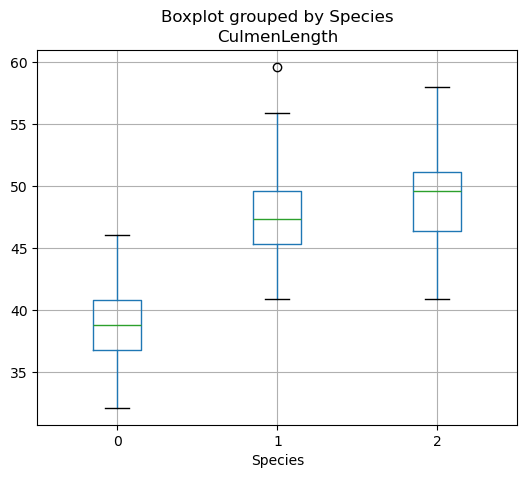

Unique values: 80


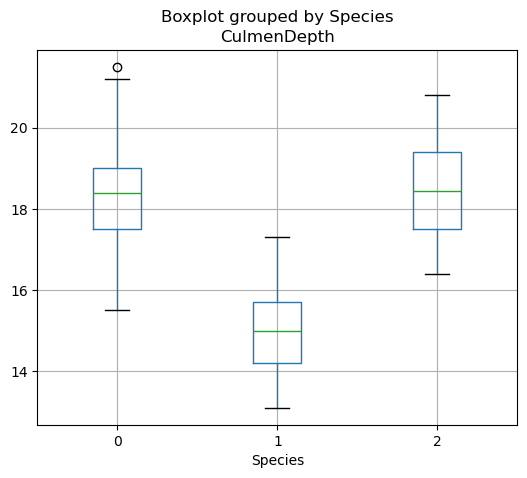

Unique values: 55


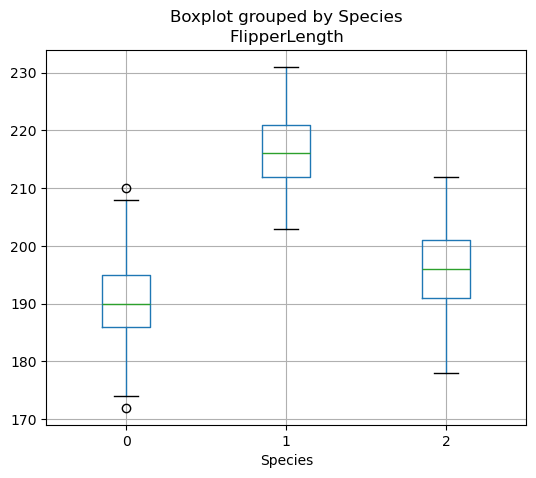

Unique values: 94


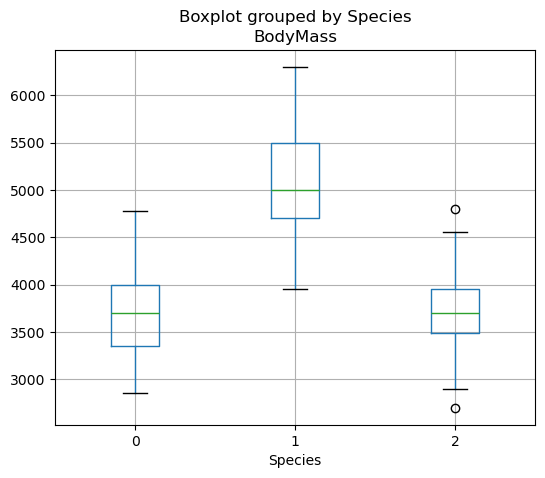

In [8]:
for col in features:
    print(f'Unique values: {len(penguins[col].unique())}')
    penguins.boxplot(column=col, by='Species', figsize=(6,5))
    plt.title(col)
    plt.show()

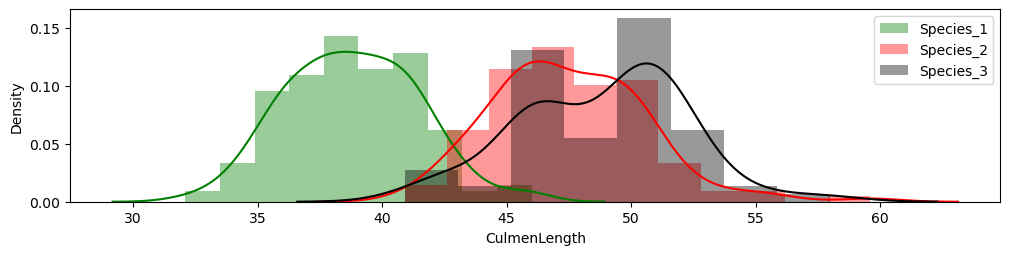

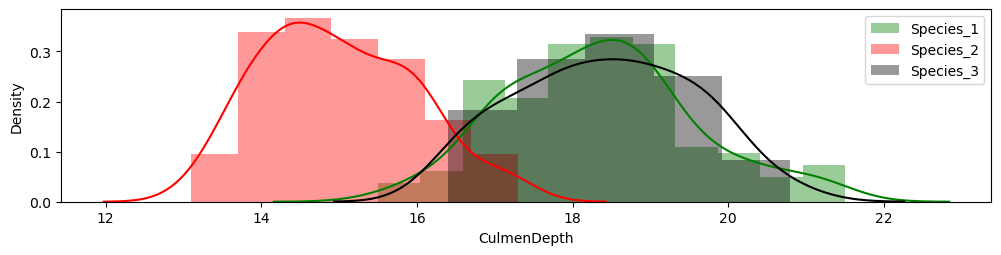

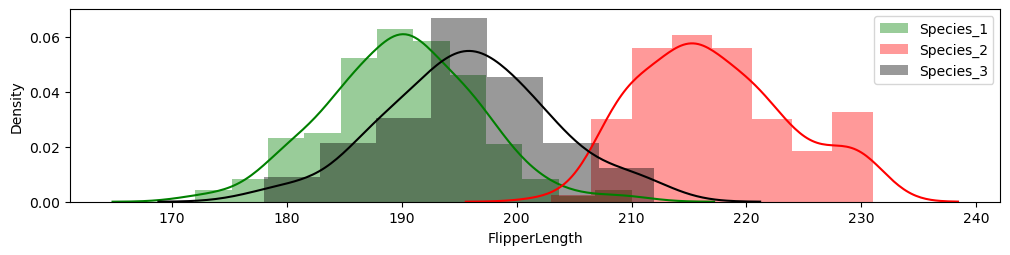

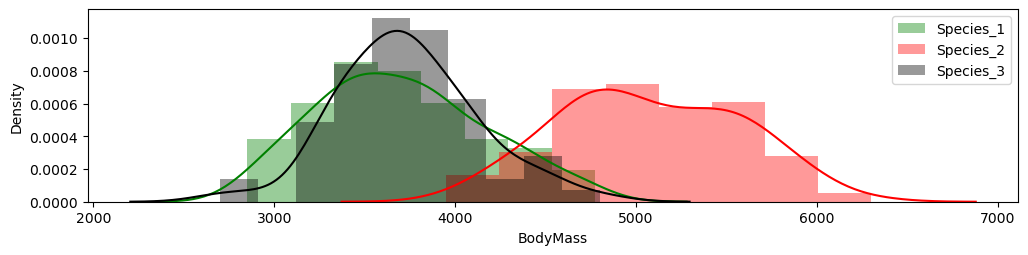

In [9]:
warnings.filterwarnings("ignore")
for col in features:
    plt.figure(figsize=(12,2.5))
    sns.distplot(penguins.loc[penguins['Species']==0, col], kde=True, color='green', label='Species_1')
    sns.distplot(penguins.loc[penguins['Species']==1, col], kde=True, color='red', label='Species_2')
    sns.distplot(penguins.loc[penguins['Species']==2, col], kde=True, color='black', label='Species_3')
    plt.legend(loc='upper right')
    plt.show()

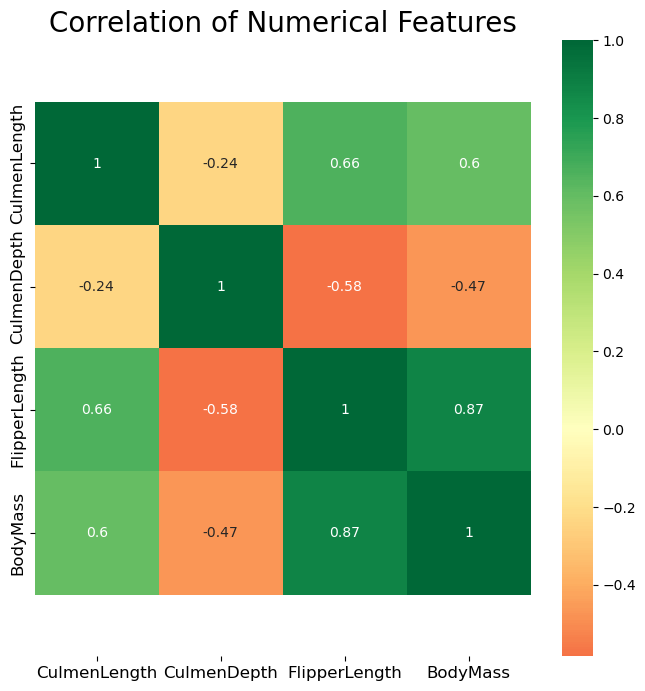

In [10]:
plt.figure(figsize=(8,8))
ax = sns.heatmap(X.corr(),
                 xticklabels=X.corr().columns,
                 yticklabels=X.corr().columns,
                 cmap='RdYlGn',
                 center=0,
                 annot=True)
plt.title('Correlation of Numerical Features', fontsize=20)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [11]:
corr_dict = {}
for col in features:
    corr_dict[col] = stats.pointbiserialr(X[col], y)[0]
pd.Series(corr_dict).sort_values(ascending=False)

CulmenLength     0.779857
FlipperLength    0.357472
BodyMass         0.209717
CulmenDepth     -0.183090
dtype: float64

**The species is most correlated with "CulmenLength" and secondarily with "FlipperLength"**

**#3 Train-test split**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X[['CulmenLength', 'FlipperLength']], y, test_size=0.30, random_state=0, stratify=y)
print('Training observations: %d\nTest observations: %d' % (X_train.shape[0], X_test.shape[0]))

Training observations: 239
Test observations: 103


**#4 Data scaling**

In [13]:
scaler_2var = StandardScaler()
X_train_standardized = scaler_2var.fit_transform(X_train)
X_test_standardized = scaler_2var.transform(X_test)

**#5 Creating DataFrame to store results**

In [14]:
metrics_dataframe = pd.DataFrame(columns=['Model', 'F1_score', 'AUC'])
models = []
models_names = []
predictions_proba_list = []

**#6 Metrics calculation function**

In [15]:
def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## Metrics for the checked model ################
    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # ROC curve
    classes = np.unique(y_checked)  # Unique classes
    plt.figure(figsize=(8, 8))
    for i, class_label in enumerate(classes):
        # Calculate FPR and TPR for each class in a one-vs-rest approach
        fpr, tpr, _ = roc_curve(y_checked == class_label, predictions_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {class_label} (AUC: {roc_auc_score(y_checked == class_label, predictions_proba[:, i]):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions, average='weighted')
    auc_metric = roc_auc_score(y_checked, predictions_proba, multi_class='ovr')
    new_row = pd.DataFrame({'Model': [name], 'F1_score': [f1_metric], 'AUC': [auc_metric]})
    metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)
    
    return metrics_dataframe

**#7 Classification surface visualization function**

In [16]:
def plot_classification_surface(X_plot, y_plot, trained_model):
    plt.figure(figsize=(12, 7))

    # Define the bounds of the dataset
    min1, max1 = X_plot[:, 0].min()-1, X_plot[:, 0].max()+1
    min2, max2 = X_plot[:, 1].min()-1, X_plot[:, 1].max()+1

    # Scale both axes
    x1grid = arange(min1, max1, 0.1)
    x2grid = arange(min2, max2, 0.1)

    # Create a grid
    xx, yy = meshgrid(x1grid, x2grid)

    # Flatten the grid
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # Create explanatory variables for the model
    grid = hstack((r1,r2))

    # Predict the model on the grid
    yhat = trained_model.predict(grid)

    # Reshape predictions to make a decision boundary
    zz = yhat.reshape(xx.shape)

    # Visualize the classification surface
    plt.contourf(xx, yy, zz, cmap='Paired', alpha=0.4)  # Adjusted for 3 classes

    # Create a scatter plot for classes in the dataset X
    for class_value in np.unique(y_plot):  # Now for each class
        # Map class (y) to observations (X)
        row_ix = where(y_plot == class_value)

        # Create the scatter plot
        plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.7, label=f'Class {class_value}')

    # Show the plot
    plt.legend(loc='upper right')
    plt.title('Classification Surface with 3 Classes')
    plt.show()

**#8 Logistic Regression Model**

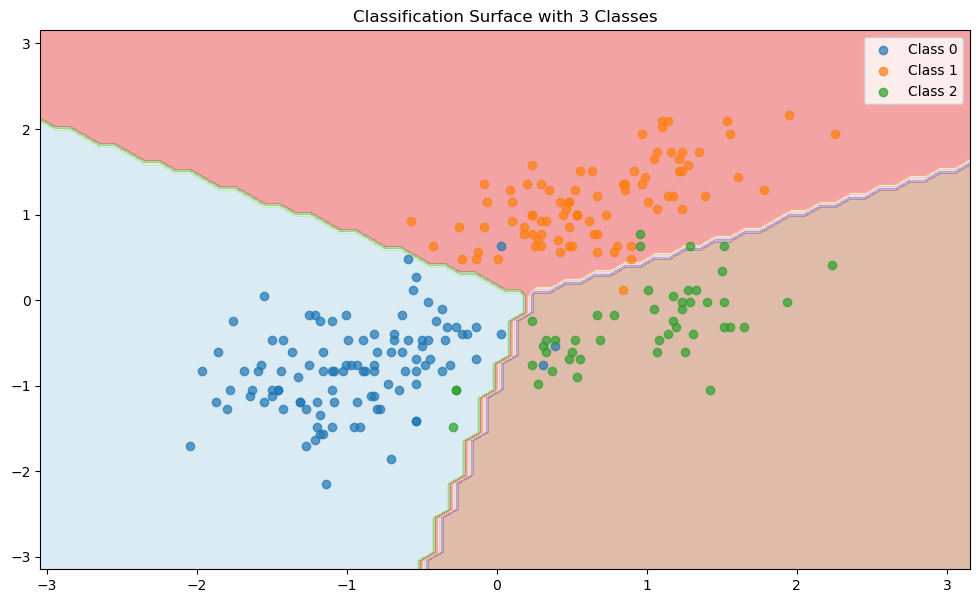

In [17]:
model_lr = LogisticRegression()
model_lr.fit(X_train_standardized, y_train)
plot_classification_surface(X_plot=X_train_standardized, y_plot=y_train, trained_model=model_lr)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        45
           1       1.00      1.00      1.00        37
           2       0.95      0.86      0.90        21

    accuracy                           0.96       103
   macro avg       0.96      0.94      0.95       103
weighted avg       0.96      0.96      0.96       103



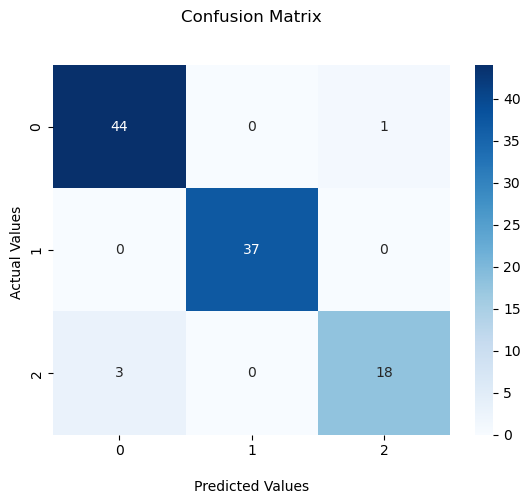

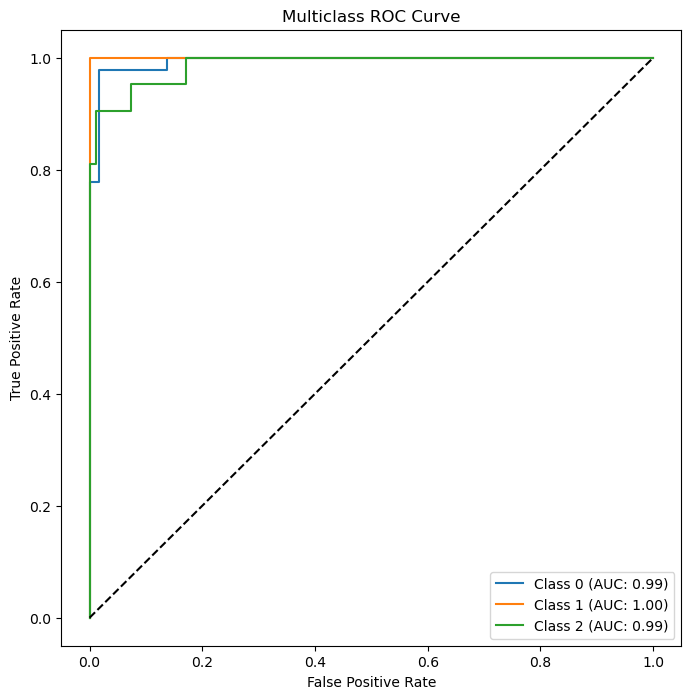

,Model,F1_score,AUC
0,Logistic Regression,0.960616,0.99357


In [18]:
calculate_metrics(model_lr, 'Logistic Regression', X_test_standardized, y_test)

**#9 KNN Model**

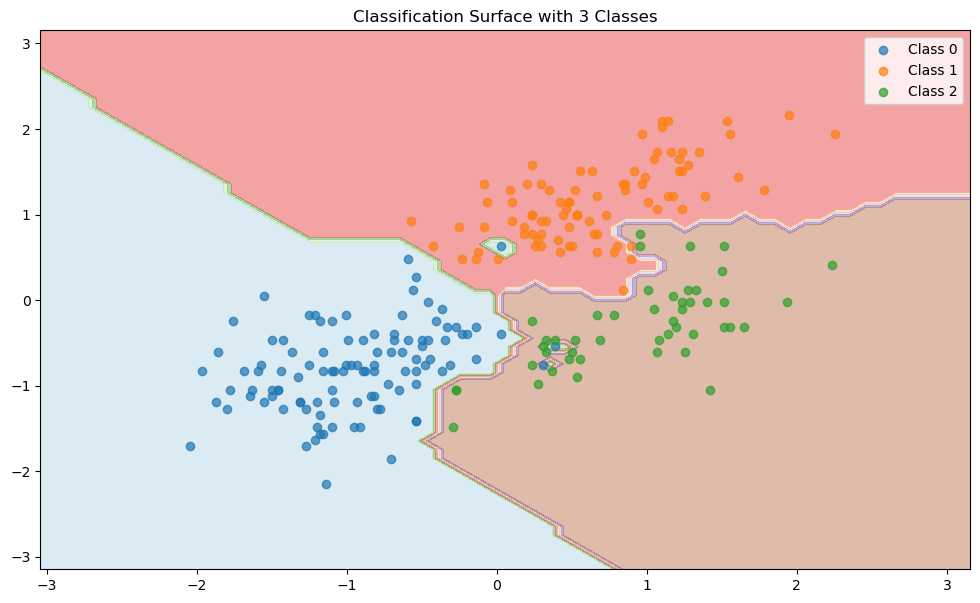

In [19]:
n_neighbors = max(1, int(X_train_standardized.shape[0] * 0.001))
model_knn = KNeighborsClassifier(n_neighbors=n_neighbors)
model_knn.fit(X_train_standardized, y_train)
plot_classification_surface(X_plot=X_train_standardized, y_plot=y_train, trained_model=model_knn)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        45
           1       1.00      0.92      0.96        37
           2       0.79      0.90      0.84        21

    accuracy                           0.93       103
   macro avg       0.92      0.93      0.92       103
weighted avg       0.94      0.93      0.93       103



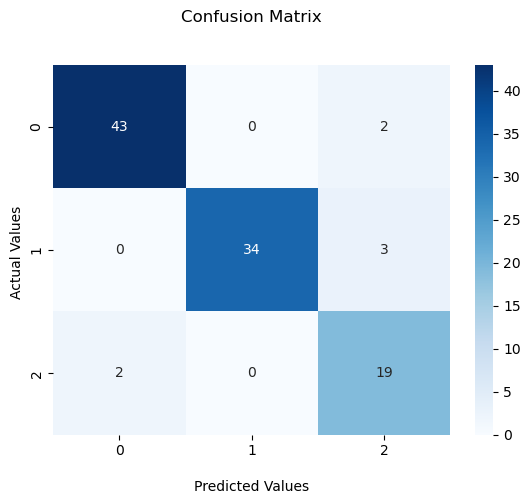

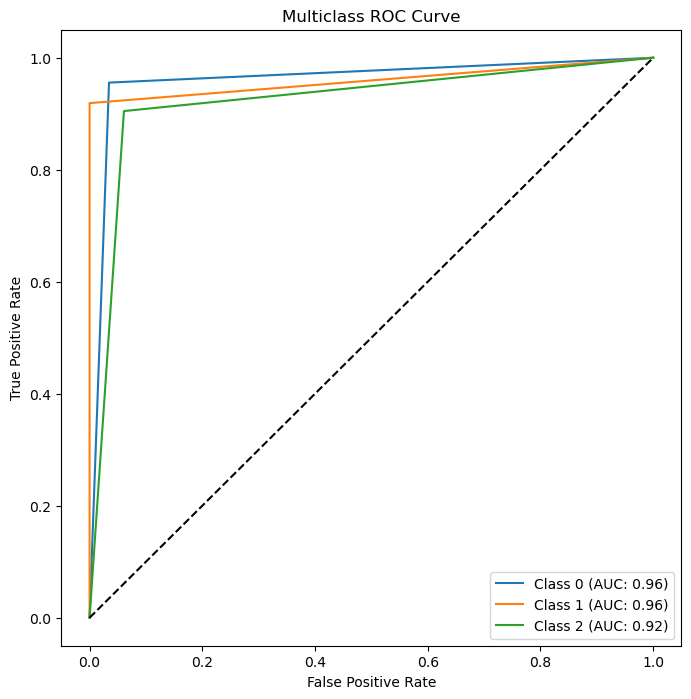

,Model,F1_score,AUC
0,Logistic Regression,0.960616,0.993570
1,KNN,0.933689,0.947296


In [20]:
calculate_metrics(model_knn, 'KNN', X_test_standardized, y_test)

**#10 Decision Tree Model**

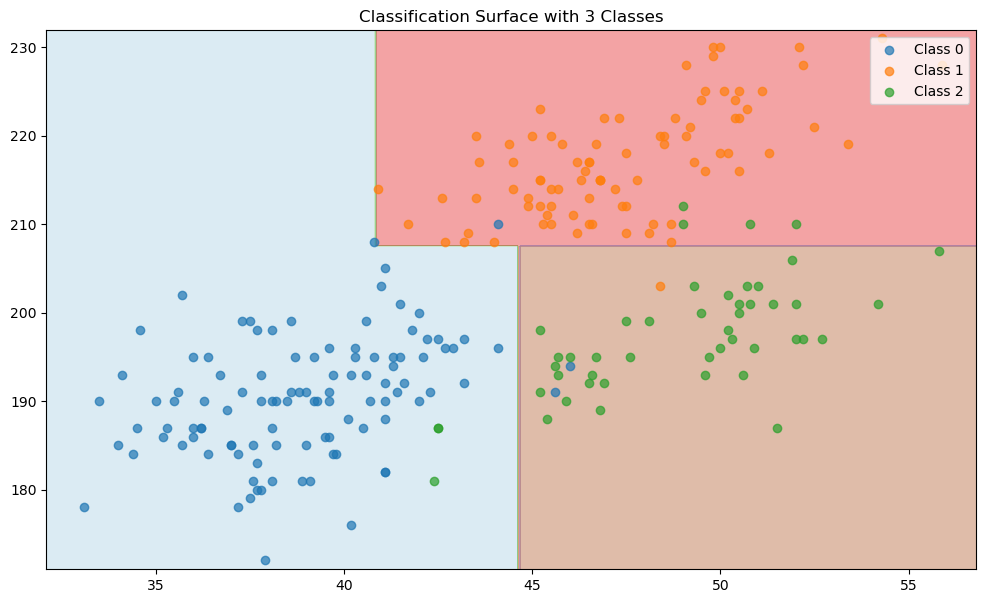

In [21]:
min_samples_leaf = max(1, int(X_train.shape[0]*0.001))
model_tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=min_samples_leaf)
model_tree.fit(X_train, y_train)
plot_classification_surface(X_plot=np.array(X_train), y_plot=y_train, trained_model=model_tree)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        45
           1       1.00      0.97      0.99        37
           2       0.90      0.86      0.88        21

    accuracy                           0.95       103
   macro avg       0.95      0.94      0.94       103
weighted avg       0.95      0.95      0.95       103



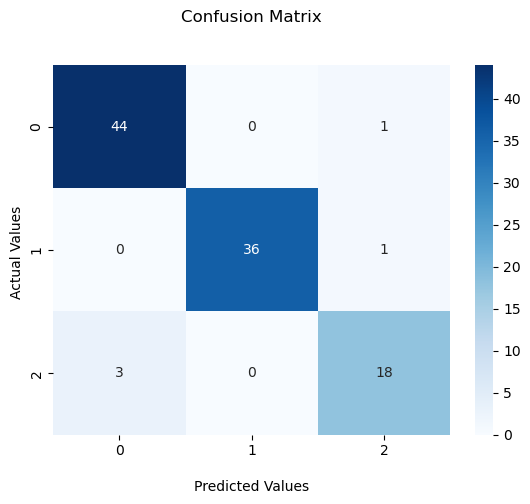

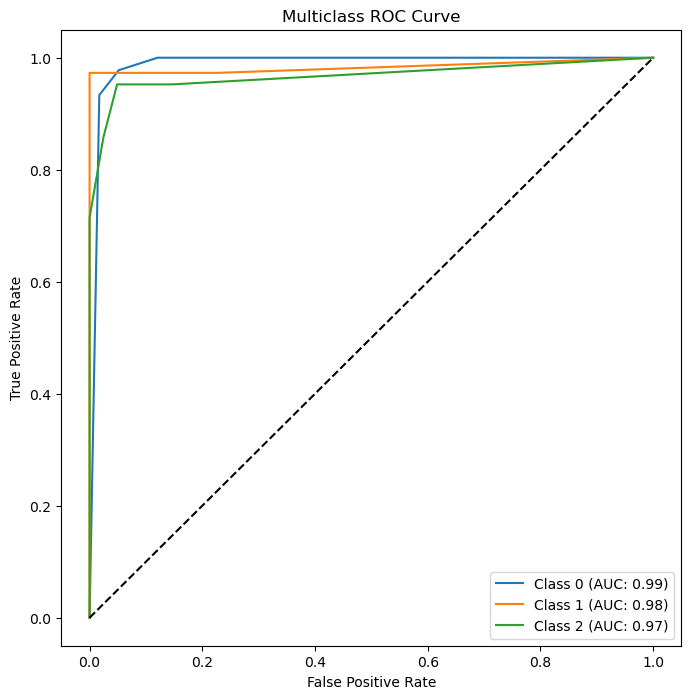

,Model,F1_score,AUC
0,Logistic Regression,0.960616,0.993570
1,KNN,0.933689,0.947296
2,Tree,0.951220,0.979800


In [22]:
calculate_metrics(model_tree, 'Tree', X_test, y_test)

**#11 SVM Model**

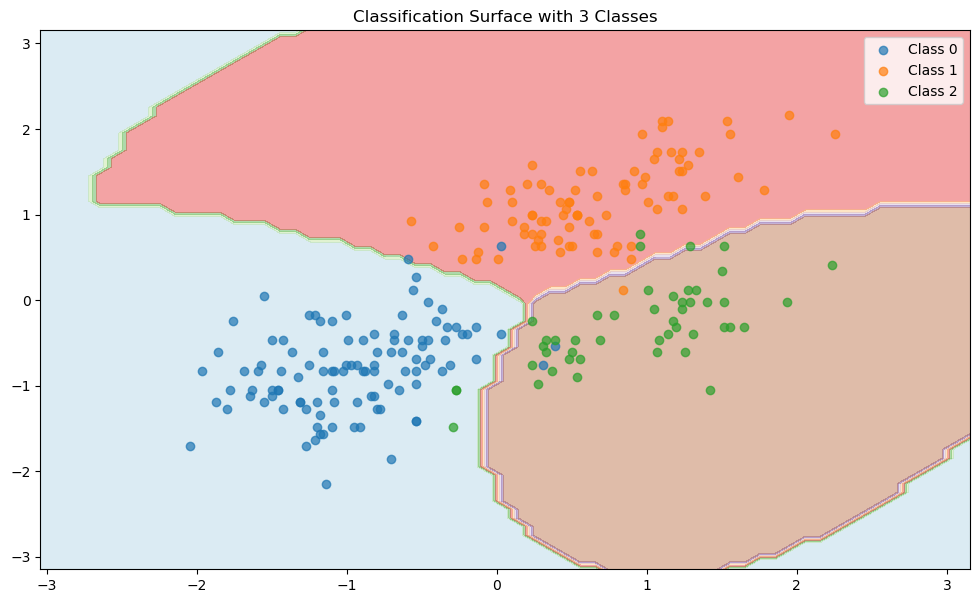

In [23]:
model_svm = SVC(kernel='rbf', probability=True)
model_svm.fit(X_train_standardized, y_train)
plot_classification_surface(X_plot=X_train_standardized, y_plot=y_train, trained_model=model_svm)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        45
           1       1.00      1.00      1.00        37
           2       0.95      0.86      0.90        21

    accuracy                           0.96       103
   macro avg       0.96      0.94      0.95       103
weighted avg       0.96      0.96      0.96       103



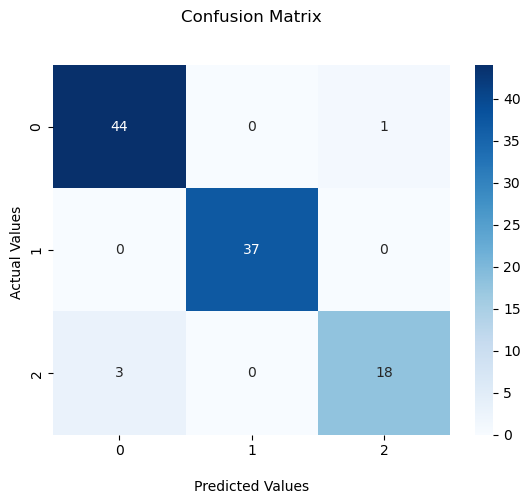

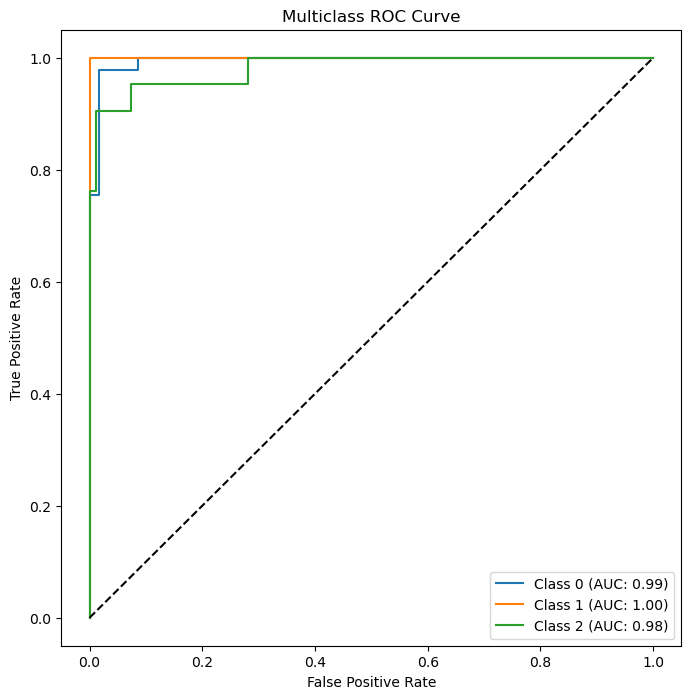

,Model,F1_score,AUC
0,Logistic Regression,0.960616,0.993570
1,KNN,0.933689,0.947296
2,Tree,0.951220,0.979800
3,SVM,0.960616,0.991890


In [24]:
calculate_metrics(model_svm, 'SVM', X_test_standardized, y_test)

**#12 Random Forest Model**

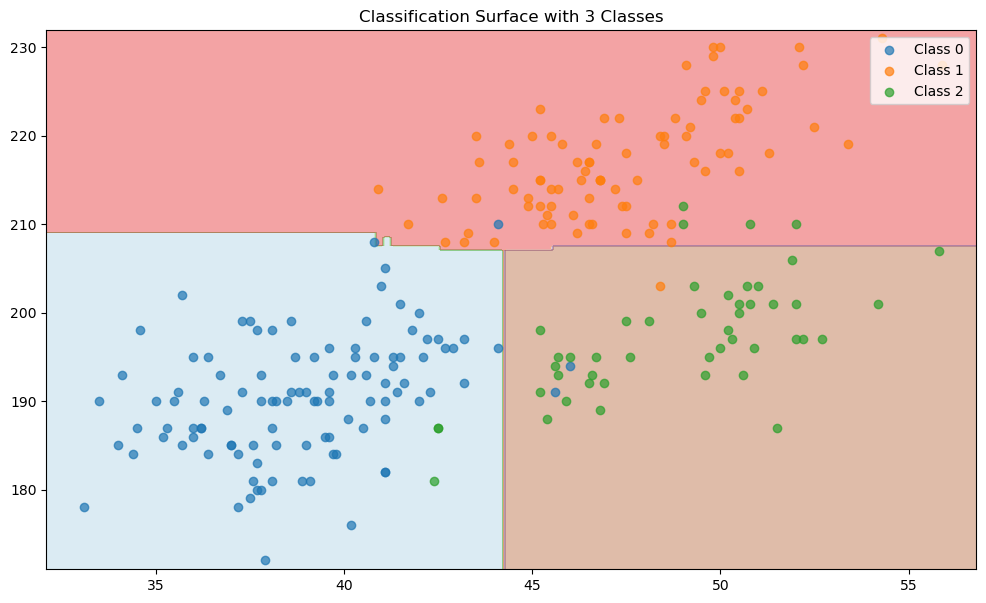

In [25]:
min_samples_leaf = max(1, int(X_train.shape[0]*0.001))
model_forest = RandomForestClassifier(n_estimators=1000, max_depth=3, min_samples_leaf=min_samples_leaf)
model_forest.fit(X_train, y_train)
plot_classification_surface(X_plot=np.array(X_train), y_plot=y_train, trained_model=model_forest)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        45
           1       1.00      0.97      0.99        37
           2       0.90      0.86      0.88        21

    accuracy                           0.95       103
   macro avg       0.95      0.94      0.94       103
weighted avg       0.95      0.95      0.95       103



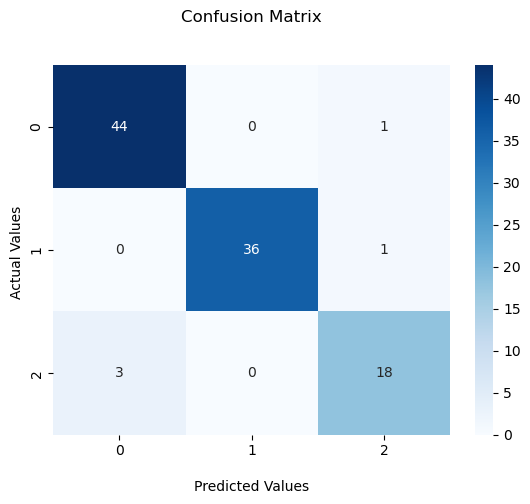

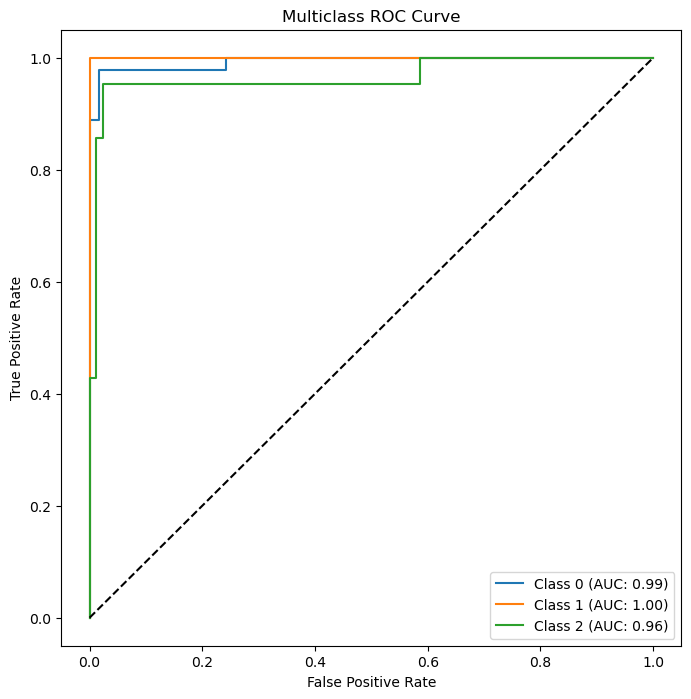

,Model,F1_score,AUC
0,Logistic Regression,0.960616,0.993570
1,KNN,0.933689,0.947296
2,Tree,0.951220,0.979800
3,SVM,0.960616,0.991890
4,RandomForest,0.951220,0.985893


In [26]:
calculate_metrics(model_forest, 'RandomForest', X_test, y_test)

**#13 AdaBoost Model**

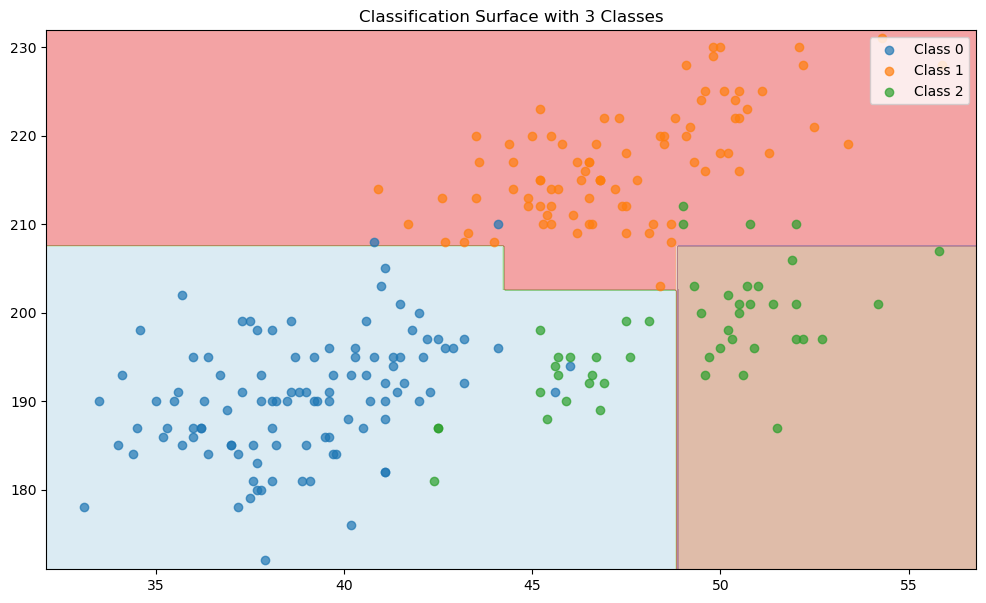

In [27]:
model_adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50)
model_adaboost.fit(X_train, y_train)
plot_classification_surface(X_plot=np.array(X_train), y_plot=y_train, trained_model=model_adaboost)

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        45
           1       1.00      1.00      1.00        37
           2       1.00      0.52      0.69        21

    accuracy                           0.90       103
   macro avg       0.94      0.84      0.86       103
weighted avg       0.92      0.90      0.89       103



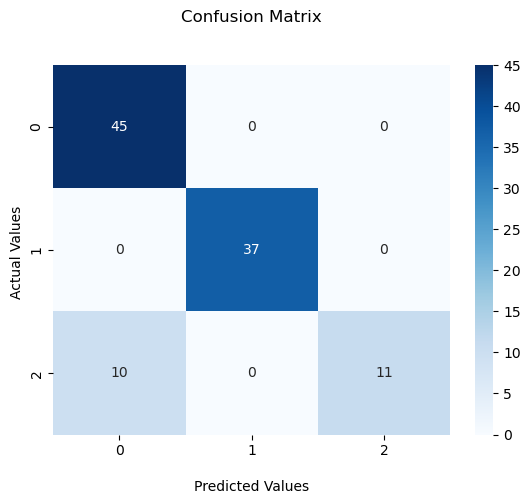

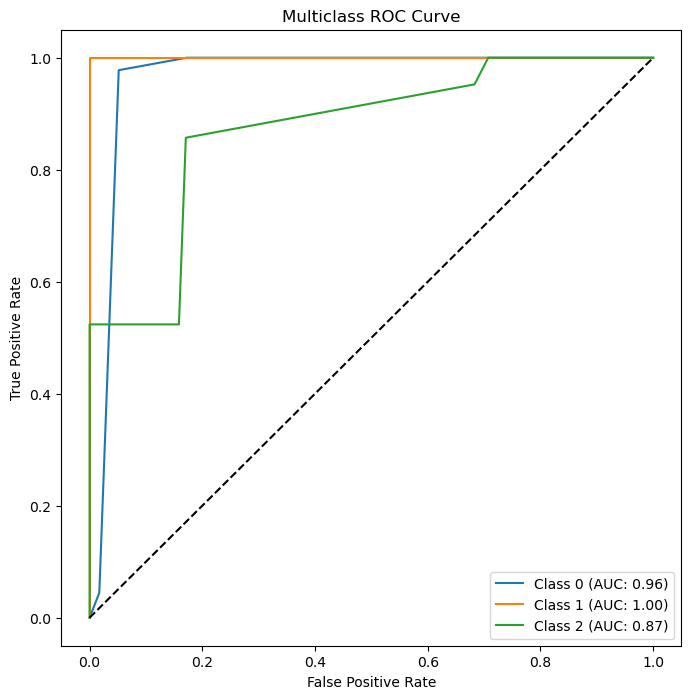

,Model,F1_score,AUC
0,Logistic Regression,0.960616,0.993570
1,KNN,0.933689,0.947296
2,Tree,0.951220,0.979800
3,SVM,0.960616,0.991890
4,RandomForest,0.951220,0.985893
5,AdaBoost,0.892597,0.945438


In [28]:
calculate_metrics(model_adaboost, 'AdaBoost', X_test, y_test)

**#14 VotingClassifier Model**

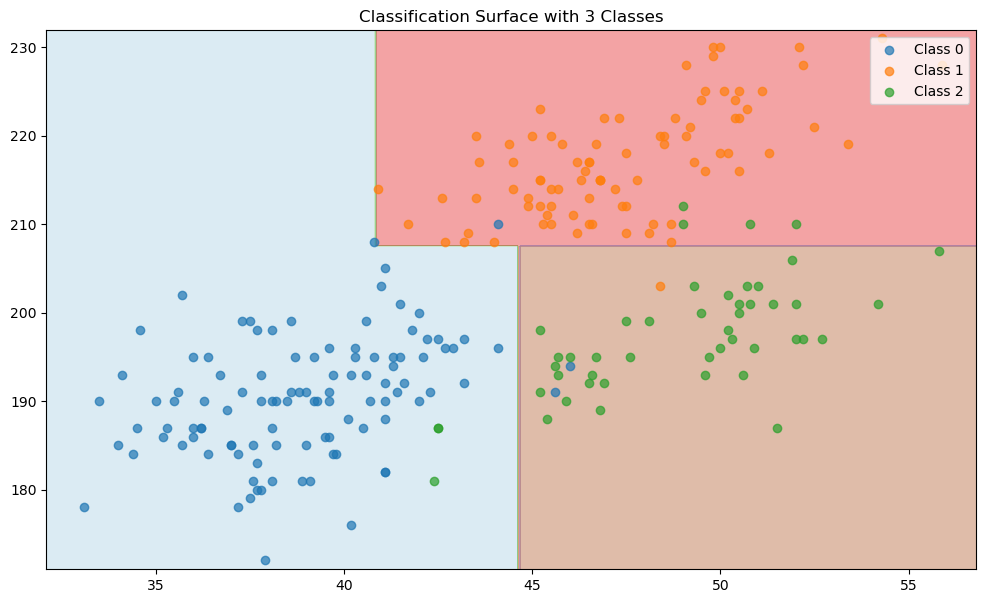

In [29]:
model_voting = VotingClassifier(estimators=[('Tree', model_tree),
                                            ('Random Forest', model_forest),
                                            ('AdaBoost', model_adaboost)],
                                voting='soft')

model_voting.fit(X_train, y_train)
plot_classification_surface(X_plot=np.array(X_train), y_plot=y_train, trained_model=model_voting)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        45
           1       1.00      0.97      0.99        37
           2       0.90      0.86      0.88        21

    accuracy                           0.95       103
   macro avg       0.95      0.94      0.94       103
weighted avg       0.95      0.95      0.95       103



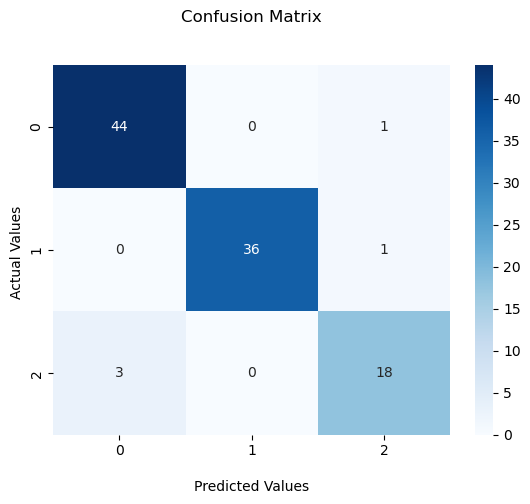

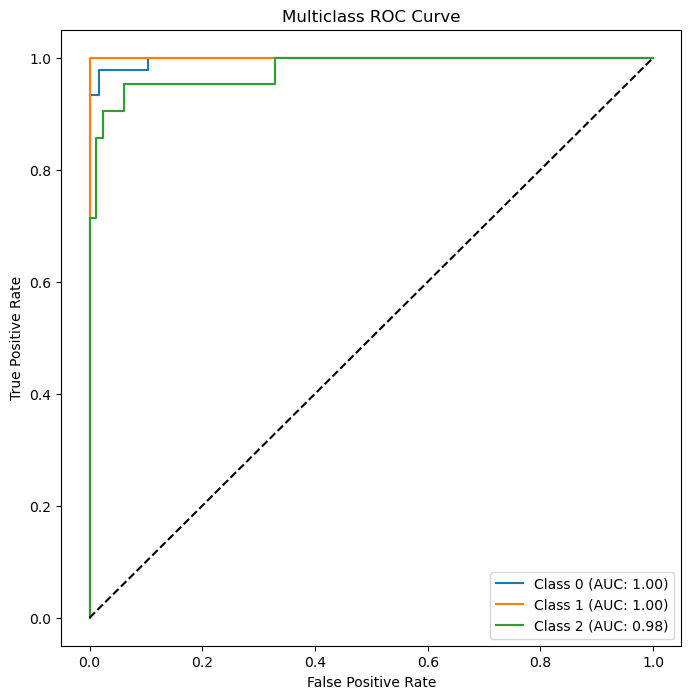

,Model,F1_score,AUC
0,Logistic Regression,0.960616,0.993570
1,KNN,0.933689,0.947296
2,Tree,0.951220,0.979800
3,SVM,0.960616,0.991890
4,RandomForest,0.951220,0.985893
5,AdaBoost,0.892597,0.945438
6,VotingClassifier,0.951220,0.991816


In [30]:
calculate_metrics(model_voting, 'VotingClassifier', X_test, y_test)

**#15 RandomForestv2 Model**

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

In [32]:
random_forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
params_rf = {'max_depth': [3, 5, 10, 20],
             'min_samples_leaf': [3, 5, 10, 15]}
rf_gridsearch = GridSearchCV(random_forest,
                             params_rf,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10, n_jobs=-1)
rf_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', rf_gridsearch.best_params_)
rf_model_v2 = rf_gridsearch.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best hyperparameter: {'max_depth': 10, 'min_samples_leaf': 3}


              precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           1       1.00      1.00      1.00        37
           2       0.95      0.90      0.93        21

    accuracy                           0.97       103
   macro avg       0.97      0.96      0.96       103
weighted avg       0.97      0.97      0.97       103



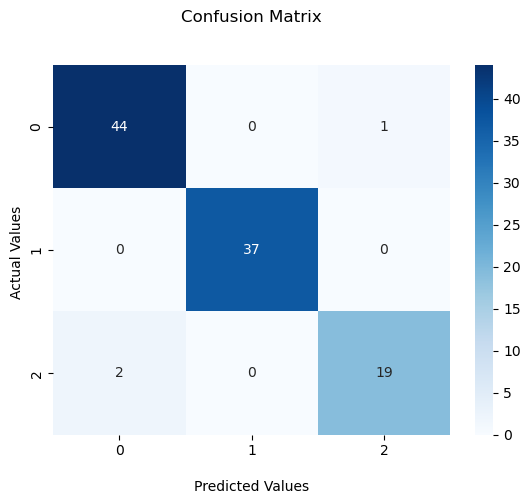

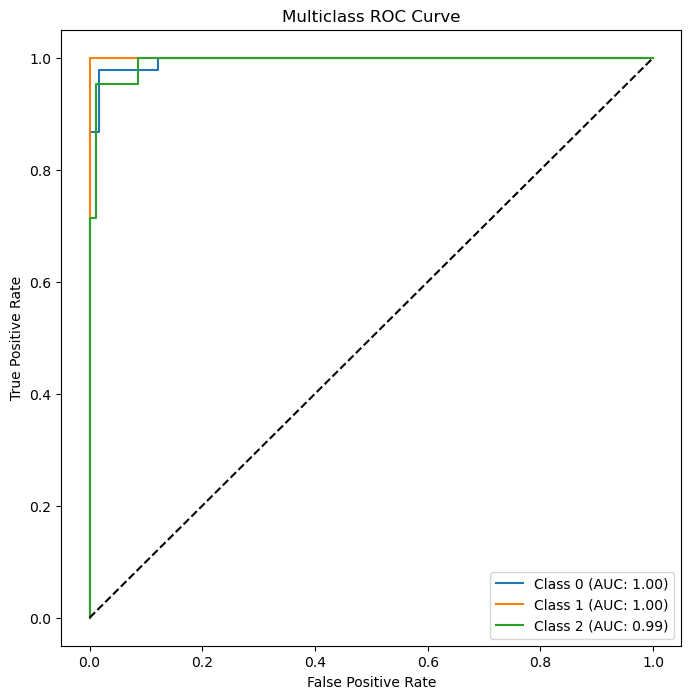

,Model,F1_score,AUC
0,Logistic Regression,0.960616,0.993570
1,KNN,0.933689,0.947296
2,Tree,0.951220,0.979800
3,SVM,0.960616,0.991890
4,RandomForest,0.951220,0.985893
5,AdaBoost,0.892597,0.945438
6,VotingClassifier,0.951220,0.991816
7,RandomForestv2,0.970679,0.996145


In [33]:
calculate_metrics(rf_model_v2, 'RandomForestv2', X_test, y_test)

**#16 Summary**

* **Logistic Regression, SVM,** and **RandomForestv2** models **achieved the highest scores** in both **F1_score and AUC**, making them the **most effective** in this table.
  
* **AdaBoost** performed **slightly worse**, suggesting it **may not be the best fit for this task.**
  
* **VotingClassifier** and **RandomForest** also performed **well**, yielding **very good results** in the **analyzed metrics.**
